In [87]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
import seaborn as sns
import fotmob_scraper as fms
from tqdm import tqdm
import requests
from PIL import Image
from io import BytesIO

# mplsoccer 
from mplsoccer import VerticalPitch, Pitch

from highlight_text import htext

In [88]:
match_id = 3624062
league_id = 69
match_url = "https://www.fotmob.com/matchDetails?matchId={}"
league_url = "https://www.fotmob.com/leagues?id={}"

api_delay=1.0

In [89]:
df_shots = pd.read_csv('data/super_leagues_shots_2223.csv')

In [90]:
df_shots.head()

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,is_own_goal,first_name,last_name,teamColor,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short
0,0,2436814335,AttemptSaved,10243,841395,Aiyegun Tosin,88.392649,38.200237,2,0.0,...,False,Aiyegun,Tosin,#18B8E8,5.965608e-01,0.054358,1.000000,3905393,FC Zürich,ZUR
1,1,2436815005,AttemptSaved,10243,1107286,Wilfried Gnonto,96.701757,41.141904,4,0.0,...,False,Wilfried,Gnonto,#18B8E8,1.423611e+00,0.322751,1.000000,3905393,FC Zürich,ZUR
2,2,2436820417,Miss,10192,694060,Meschack Elia,86.138239,33.466249,19,0.0,...,False,Meschack,Elia,#000000,-2.220446e-16,0.237354,0.529271,3905393,Young Boys,YB
3,3,2436820591,AttemptSaved,10243,976577,Bledian Krasniqi,74.939324,46.523057,20,0.0,...,False,Bledian,Krasniqi,#18B8E8,1.161376e+00,0.183459,1.000000,3905393,FC Zürich,ZUR
4,4,2436820967,AttemptSaved,10192,694060,Meschack Elia,87.641173,34.533751,21,0.0,...,False,Meschack,Elia,#000000,1.040344e+00,0.322751,1.000000,3905393,Young Boys,YB


In [91]:
team_colors: dict = {
    'BAS': '#FF1433', 
    'ZUR': '#00BFFF', 
    'GRA': '#0064B9', 
    'LAU': '#006EB7', 
    'LUG': '#000000', 
    'LUZ': '#154281', 
    'SER': '#870E26', 
    'SIO': '#EC1F00', 
    'GAL': '#008141',
    'YB': '#FFD940',
    'WIN':'#AB0707', 
    'AVG': '#FFFFFF'
}

In [92]:
team_logo_url = {
    'YB': "https://images.fotmob.com/image_resources/logo/teamlogo/10192.png", 
    'LUZ': "https://images.fotmob.com/image_resources/logo/teamlogo/10199.png", 
    'GAL': "https://images.fotmob.com/image_resources/logo/teamlogo/10190.png", 
    'LAU': "https://images.fotmob.com/image_resources/logo/teamlogo/7730.png", 
    'LUG': "https://images.fotmob.com/image_resources/logo/teamlogo/7896.png", 
    'ZUR': "https://images.fotmob.com/image_resources/logo/teamlogo/10243.png", 
    'GRA': "https://images.fotmob.com/image_resources/logo/teamlogo/9956.png", 
    'BAS': "https://images.fotmob.com/image_resources/logo/teamlogo/9931.png",
    'SER': "https://images.fotmob.com/image_resources/logo/teamlogo/9777.png",
    'SIO': "https://images.fotmob.com/image_resources/logo/teamlogo/10179.png",
    'WIN': "https://images.fotmob.com/image_resources/logo/teamlogo/7894.png"
    }

In [93]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [94]:
df_shots.isnull().sum()

Unnamed: 0                     0
shot_id                        0
event_type                     0
team_id                        0
player_id                      0
player_name                    0
x_coord                        0
y_coord                        0
minutes                        0
minutes_added                  0
is_blocked                     0
is_on_target                   0
blocked_x_coord             1063
blocked_y_coord             1063
goal_crossed_y_coord           0
goal_crossed_z_coord           0
expected_goals                 7
expected_goals_on_target    1504
shot_type                      0
situation                      0
period                         0
is_own_goal                    0
first_name                    30
last_name                      0
teamColor                      0
on_goal_shot_x_coord           0
on_goal_shot_y_coord           0
on_goal_shot_zoom_ratio        0
match_id                       0
team                           0
team_short

In [95]:
df_shots[df_shots['expected_goals'].isnull()]

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,is_own_goal,first_name,last_name,teamColor,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short
62,62,2437213091,Goal,7896,113239,Fabio Daprela,3.129310,36.287500,43,0.0,...,True,Fabio,Daprela,#101010,1.887566,0.129101,1.0,3905400,Lugano,LUG
587,587,2445649941,Goal,10199,189980,Denis Simani,4.077586,35.219999,51,0.0,...,True,Denis,Simani,#083890,1.766534,0.064550,1.0,3905439,Luzern,LUZ
726,726,2451851071,Goal,9777,769334,Yoan Severin,32.313108,37.864049,20,0.0,...,True,Yoan,Severin,#900028,1.504299,0.022083,1.0,3905447,Servette,SER
1106,1106,2465794583,Goal,10190,615411,Lawrence Ati-Zigi,2.181034,35.982499,17,0.0,...,True,Lawrence,Ati-Zigi,#097D35,0.092262,0.203843,1.0,3905409,St. Gallen,GAL
1292,1292,2469249311,Goal,10190,1019947,Leonidas Stergiou,3.034483,34.991249,87,0.0,...,True,Leonidas,Stergiou,#097D35,0.778108,0.377109,1.0,3905425,St. Gallen,GAL
1728,1728,2476416589,Goal,9777,562906,Patrick Pflucke,9.263158,34.686251,53,0.0,...,True,Patrick,Pflucke,#900028,1.645503,0.203843,1.0,3905455,Servette,SER
2227,2227,2499698575,Goal,7896,485148,Ousmane Doumbia,4.836207,33.466249,76,0.0,...,True,Ousmane,Doumbia,#101010,1.262235,0.074742,1.0,3905474,Lugano,LUG


In [96]:
df_shots['player_name'].value_counts(ascending=False)

Zan Celar             40
Patrick Pflucke       39
Chadrac Akolo         38
Aiyegun Tosin         37
Dan Ndoye             37
                      ..
Luca Zuffi             1
Lawrence Ati-Zigi      1
Valton Behrami         1
Michael Goncalves      1
Alessandro Kräuchi     1
Name: player_name, Length: 210, dtype: int64

In [97]:
df_shots.columns

Index(['Unnamed: 0', 'shot_id', 'event_type', 'team_id', 'player_id',
       'player_name', 'x_coord', 'y_coord', 'minutes', 'minutes_added',
       'is_blocked', 'is_on_target', 'blocked_x_coord', 'blocked_y_coord',
       'goal_crossed_y_coord', 'goal_crossed_z_coord', 'expected_goals',
       'expected_goals_on_target', 'shot_type', 'situation', 'period',
       'is_own_goal', 'first_name', 'last_name', 'teamColor',
       'on_goal_shot_x_coord', 'on_goal_shot_y_coord',
       'on_goal_shot_zoom_ratio', 'match_id', 'team', 'team_short'],
      dtype='object')

In [98]:
df_cabral_shots = df_shots[df_shots['player_name']== 'Arthur Cabral']

In [99]:
df_cabral_shots[['event_type','shot_type','x_coord','y_coord']].head()

,event_type,shot_type,x_coord,y_coord


In [100]:
df_cabral_shots[['x_coord','y_coord']].describe()

,x_coord,y_coord
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


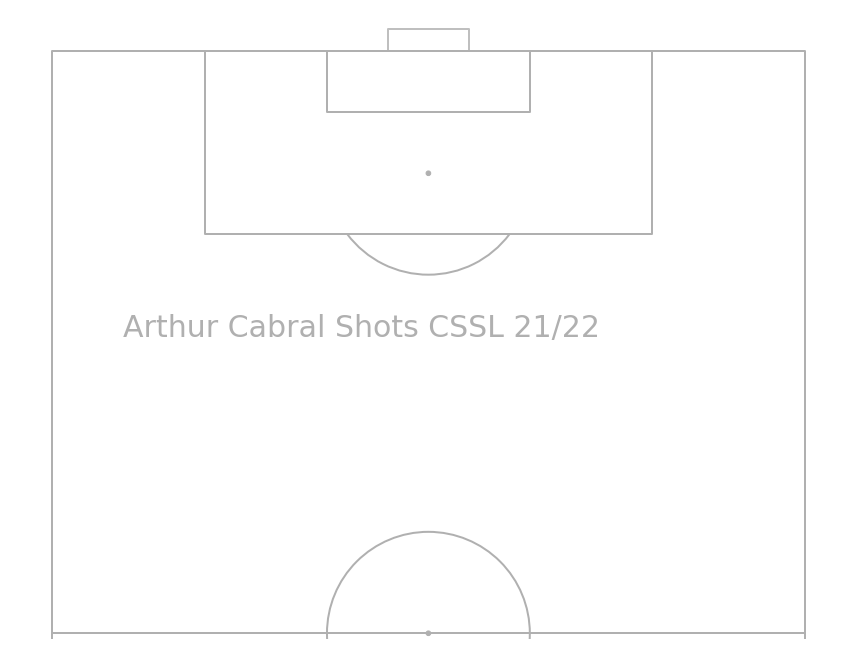

In [101]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
saved_right = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'expected_goals'] * 900) + 100, c='blue',edgecolors='#383838',marker='h', ax=ax)
saved_left = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'expected_goals'] * 900) + 100, c='blue',edgecolors='#383838',marker='o', ax=ax)
saved_left = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'expected_goals'] * 900) + 100, c='blue',edgecolors='#383838',marker='s', ax=ax)

goals = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'expected_goals'] * 900) + 100, c='red',edgecolors='#383838',marker='h', ax=ax)
goals = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'expected_goals'] * 900) + 100, c='red',edgecolors='#383838',marker='o', ax=ax)
goals = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'expected_goals'] * 900) + 100, c='red',edgecolors='#383838',marker='s', ax=ax)


txt = ax.text(x=40, y=80, s='Arthur Cabral Shots CSSL 21/22', size=30, color= pitch.line_color, va='center', ha='center')

# Shotmaps V2 
## prettier viz with help by Tutorial of Peter McKeever

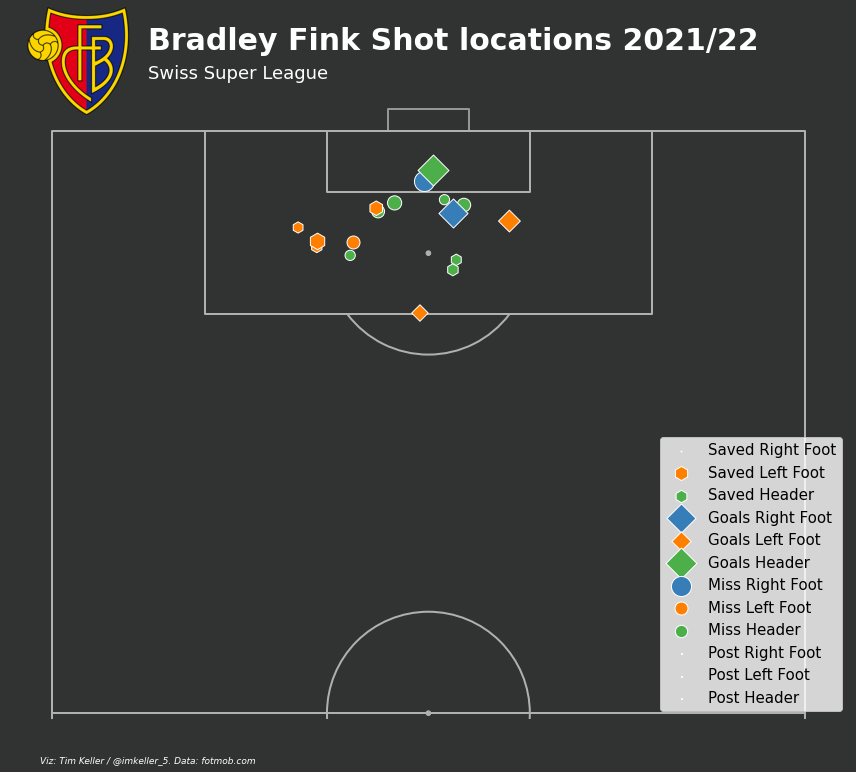

In [141]:
players = df_shots.loc[df_shots['event_type']=='Goal','player_name'].value_counts().head(20).index.tolist()
player = players[12]
season = "2021/22"
title_font = "Alegreya Sans"
body_font = "Open Sans"
text_color = "w"
background = "#313332"
edge = "white"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

saved_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='h', ax=ax, zorder=15)

miss_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='o', ax=ax, zorder=5)

post_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='s', ax=ax, zorder=10)
post_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='s', ax=ax, zorder=10)
post_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='s', ax=ax, zorder=10)

goals_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='D', ax=ax, zorder=20)
goals_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='D', ax=ax, zorder=20)
goals_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='D', ax=ax, zorder=20)


plt.legend(handles=[saved_right, saved_left, saved_header, goals_right, goals_left, goals_header, miss_right, miss_left, miss_header,post_right,post_left,post_header], labels=['Saved Right Foot', 'Saved Left Foot', 'Saved Header', 'Goals Right Foot', 'Goals Left Foot', 'Goals Header','Miss Right Foot','Miss Left Foot','Miss Header','Post Right Foot','Post Left Foot','Post Header'], loc='lower right', fontsize=10, prop={'size': 15})

ax2 = fig.add_axes([0.02,0.9,0.15,0.15]) # badge
ax2.axis('off')
url = team_logo_url[df_shots.loc[df_shots['player_name']==player,'team_short'].unique()[0]]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

fig.text(0.05, 0.0, "Viz: Tim Keller / @imkeller_5. Data: fotmob.com",
        fontstyle="italic",fontsize=9, fontfamily=body_font, color=text_color)

string = '{} Shot locations {}'.format(player,season)
fig.text(0.175,0.99,string, fontsize=30, fontfamily=title_font, color=text_color, fontweight='bold')
fig.text(0.175,0.95,'Swiss Super League', fontweight='regular',fontsize=18, fontfamily=title_font,color=text_color)


plt.tight_layout()
plt.show()

fig.savefig('figs/{}_shotmap.jpg'.format(player).lower().replace(' ','_'),bbox_inches='tight')

In [140]:
players

['Jean Pierre Nsame',
 'Zan Celar',
 'Max Meyer',
 'Emmanuel Latte Lath',
 'Cedric Itten',
 'Hayao Kawabe',
 'Jeremy Guillemenot',
 'Mario Balotelli',
 'Filip Stojilkovic',
 'Lukas Görtler',
 'Aiyegun Tosin',
 'Renat Dadashov',
 'Bradley Fink',
 'Chadrac Akolo',
 'Meschack Elia',
 'Dejan Sorgic',
 'Mohamed Amoura',
 'Marco Burch',
 'Renato Steffen',
 'Giovanni Sio']

In [104]:
df_cabral_shots['shot_type'].unique()

array([], dtype=object)

In [105]:
df_cabral_shots['event_type'].unique()

array([], dtype=object)

In [106]:
df_cabral_shots.loc[df_cabral_shots['event_type']=='Goal']

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,is_own_goal,first_name,last_name,teamColor,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short


In [107]:
df_cabral_shots.columns

Index(['Unnamed: 0', 'shot_id', 'event_type', 'team_id', 'player_id',
       'player_name', 'x_coord', 'y_coord', 'minutes', 'minutes_added',
       'is_blocked', 'is_on_target', 'blocked_x_coord', 'blocked_y_coord',
       'goal_crossed_y_coord', 'goal_crossed_z_coord', 'expected_goals',
       'expected_goals_on_target', 'shot_type', 'situation', 'period',
       'is_own_goal', 'first_name', 'last_name', 'teamColor',
       'on_goal_shot_x_coord', 'on_goal_shot_y_coord',
       'on_goal_shot_zoom_ratio', 'match_id', 'team', 'team_short'],
      dtype='object')

In [108]:
df_cabral_shots.head()

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,is_own_goal,first_name,last_name,teamColor,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short


# Erster Versuch Shots Heat Map 
## (in use case schwierig umsetzbar, kaum Aussagekräftig)

In [109]:
xdim, ydim = 50, 30 
shot_surface = np.zeros((xdim, ydim), dtype=np.float)
cabral_shot_surface = np.zeros((xdim, ydim), dtype=np.float)

/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/2376832350.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shot_surface = np.zeros((xdim, ydim), dtype=np.float)
/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/2376832350.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cabral_shot_surface = np.zeros

In [110]:
shot_points= np.array([df_shots['x_coord'], df_shots['y_coord']]).T
cabral_shot_points = np.array([df_cabral_shots['x_coord'], df_cabral_shots['y_coord']]).T


In [111]:
x_bins = np.linspace(0,105, xdim)
y_bins = np.linspace(0,68, ydim)

In [112]:
for points, surface in [(shot_points, shot_surface),(cabral_shot_points, cabral_shot_surface)]:
    for x, y in points:
        x_index = np.digitize(x, x_bins)
        y_index = np.digitize(y, y_bins)
        try:
            surface[x_index, y_index] += 1 / len(points)
        except IndexError:
            pass

In [113]:
df_shots.columns

Index(['Unnamed: 0', 'shot_id', 'event_type', 'team_id', 'player_id',
       'player_name', 'x_coord', 'y_coord', 'minutes', 'minutes_added',
       'is_blocked', 'is_on_target', 'blocked_x_coord', 'blocked_y_coord',
       'goal_crossed_y_coord', 'goal_crossed_z_coord', 'expected_goals',
       'expected_goals_on_target', 'shot_type', 'situation', 'period',
       'is_own_goal', 'first_name', 'last_name', 'teamColor',
       'on_goal_shot_x_coord', 'on_goal_shot_y_coord',
       'on_goal_shot_zoom_ratio', 'match_id', 'team', 'team_short'],
      dtype='object')

In [114]:
len(shot_points), len(cabral_shot_points)

(2276, 0)

In [115]:
shot_surface / len(shot_points)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

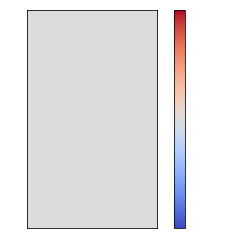

In [116]:
plt.imshow(cabral_shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

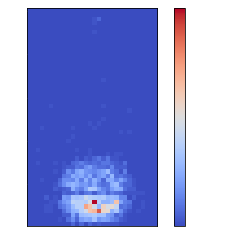

In [117]:
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

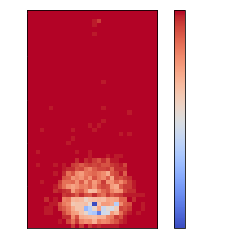

In [118]:
plt.imshow(cabral_shot_surface-shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

In [119]:
from scipy.ndimage import gaussian_filter

In [120]:
len(shot_surface), len(cabral_shot_surface)

(50, 50)

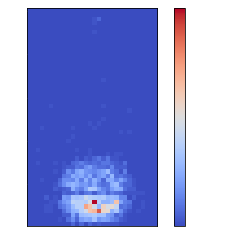

In [121]:
diff_cabral_shot_surface = gaussian_filter(cabral_shot_surface-shot_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

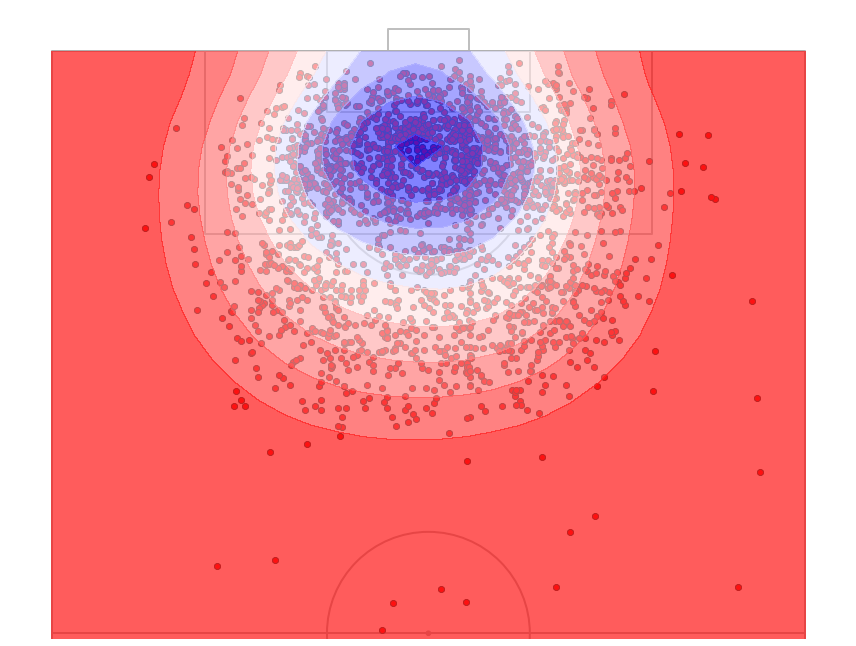

In [122]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
z = np.rot90(gaussian_filter(diff_cabral_shot_surface, sigma=2.2), 0)

ax.contourf(y_bins,x_bins, z, zorder=2, levels=10, alpha=0.7, cmap='bwr')

pitch.scatter(df_cabral_shots['x_coord'], df_cabral_shots['y_coord'], c='blue',edgecolors='#383838',marker='h', ax=ax)
pitch.scatter(df_cabral_shots['x_coord'], df_cabral_shots['y_coord'], c='blue',edgecolors='#383838',marker='o', ax=ax)

pitch.scatter(df_shots['x_coord'], df_shots['y_coord'], c='red',edgecolors='#383838',marker='h', ax=ax)
pitch.scatter(df_shots['x_coord'], df_shots['y_coord'], c='red',edgecolors='#383838',marker='o', ax=ax)


ax.set_aspect(1)
ax.axis('off')
plt.show()

# Shotmaps Teams

In [123]:
df_shots['team_short'].unique()

array(['ZUR', 'YB', 'WIN', 'BAS', 'LUG', 'SIO', 'GAL', 'SER', 'LUZ',
       'GRA'], dtype=object)

In [124]:
df_shots['situation'].unique()

array(['RegularPlay', 'SetPiece', 'FromCorner', 'FastBreak', 'Penalty',
       'FreeKick', 'IndividualPlay', 'ThrowInSetPiece'], dtype=object)

In [125]:
xdim, ydim = 50, 30 
league_shot_surface = np.zeros((xdim, ydim), dtype=np.float)
team_shot_surface = np.zeros((xdim, ydim), dtype=np.float)
team = 'LUG'
team_shot_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'expected_goals']]).T
league_shot_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'expected_goals']]).T
x_bins = np.linspace(0,105, xdim)
y_bins = np.linspace(0,68, ydim)

/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/3215172769.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  league_shot_surface = np.zeros((xdim, ydim), dtype=np.float)
/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/3215172769.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  team_shot_surface = np.

In [126]:
for points, surface in [(league_shot_points, league_shot_surface),(team_shot_points, team_shot_surface)]:
    
    for x, y, xg in points:
        x_index = np.digitize(x, x_bins)
        y_index = np.digitize(y, y_bins)
        try:
            surface[x_index, y_index] += 1 * xg / len(points)
        except IndexError:
            pass

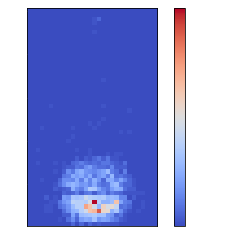

In [127]:
diff_team_shot_surface = gaussian_filter(team_shot_surface-league_shot_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/2691015905.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  sm.cmap.set_under('darkblue')
/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/2691015905.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  sm.cmap.set_over('darkred')


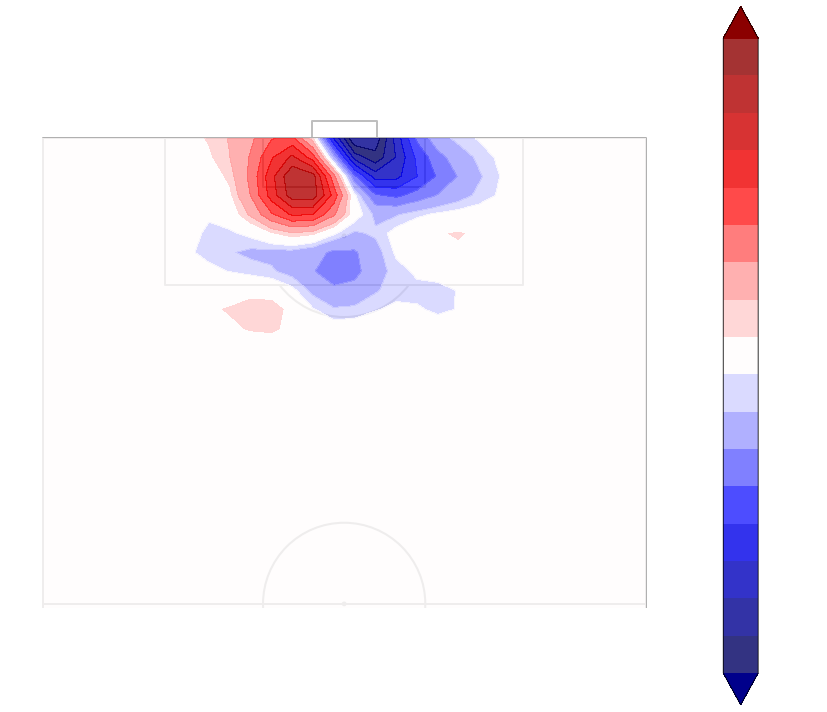

In [128]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
z = diff_team_shot_surface
levels = [-0.0004,-0.00035,-0.0003,-0.00025,-0.0002,-0.00015,-0.0001,-0.00005,-0.000025,0.000025,0.00005,0.0001,0.00015,0.0002,0.00025,0.0003,0.00035,0.0004]
sm = ax.contourf(y_bins,x_bins, z, zorder=2, levels=levels, alpha=0.8, cmap='seismic', extend='both')
sm.cmap.set_under('darkblue')
sm.cmap.set_over('darkred')
ax.set_aspect(1)
ax.axis('off')

cbar = fig.colorbar(sm)

plt.show()
fig.savefig('figs/{}-shotmap.jpg'.format(team.lower()),bbox_inches='tight')

- BAS: -0.00016, 0.00000
- YB : -0.00038, 0.00016
- ZUR: -0.00040, 0.00032
- GAL: -0.00035, 0.00005

## Shotmaps Finishing


In [129]:
league_shot_fin_surface = np.zeros((xdim, ydim), dtype=np.float)
team_shot_fin_surface = np.zeros((xdim, ydim), dtype=np.float)

/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/3486468348.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  league_shot_fin_surface = np.zeros((xdim, ydim), dtype=np.float)
/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/3486468348.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  team_shot_fin_surfa

In [130]:
team_shot_fin_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'expected_goals'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'event_type']]).T
league_shot_fin_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'expected_goals'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'event_type']]).T

In [131]:
for points, surface in [(league_shot_fin_points, league_shot_fin_surface),(team_shot_fin_points, team_shot_fin_surface)]:
    
    for x, y, xg, type in points:
        x_index = np.digitize(x, x_bins)
        y_index = np.digitize(y, y_bins)
        try:
            if type == 'Goal':
                surface[x_index, y_index] += (1 - xg) / len(points)
            else: 
                surface[x_index, y_index] -= xg / len(points)
        except IndexError:
            pass

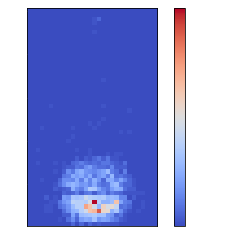

In [132]:
league_shot_fin = gaussian_filter(league_shot_fin_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

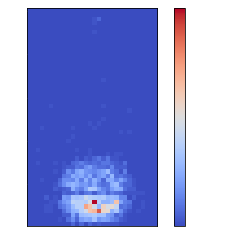

In [133]:
team_shot_fin = gaussian_filter(team_shot_fin_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

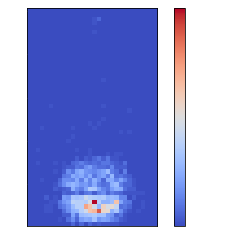

In [134]:
diff_team_fin_surface = gaussian_filter(team_shot_fin_surface-league_shot_fin_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/3056343985.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  smf.cmap.set_under('darkblue')
/var/folders/gf/v8lw1m9d0x9454xmvtfnbbqm0000gn/T/ipykernel_34068/3056343985.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  smf.cmap.set_over('darkred')


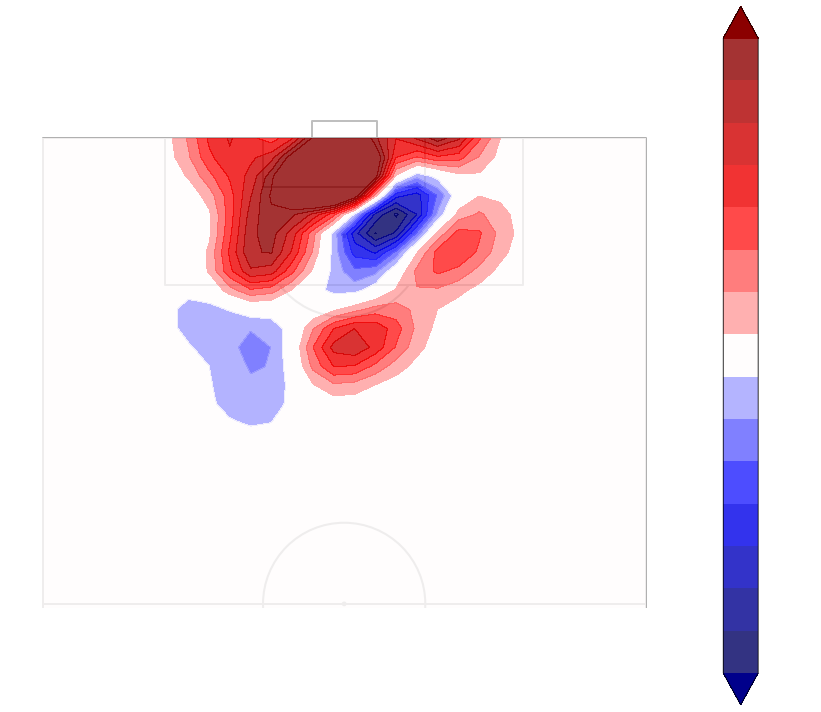

In [135]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
z = diff_team_fin_surface
levels=[-0.00048,-0.00042,-0.00036,-0.00030,-0.00024,-0.00018,-0.00012,-0.00006,0.00006,0.00012,0.00018,0.00024,0.00030,0.00036,0.00042,0.00048]
smf = ax.contourf(y_bins,x_bins, z, zorder=2, levels=levels, alpha=0.8, cmap='seismic', extend='both')
smf.cmap.set_under('darkblue')
smf.cmap.set_over('darkred')
ax.set_aspect(1)
ax.axis('off')
cbar = fig.colorbar(smf)

plt.show()


fig.savefig('figs/{}-finishing-shotmap.jpg'.format(team.lower()),bbox_inches='tight')

- BAS: -0.00016, 0.00012
- YB : -0.00036, 0.00024
- ZUR: -0.0001, 0.0006
- GAL: -0.0006, 0.0002

In [136]:
[-48,24,12,0,12,24,36,48]

[-48, 24, 12, 0, 12, 24, 36, 48]

In [137]:
df_shots.loc[df_shots['event_type']=='Goal','player_name'].value_counts().head(10).index.tolist()

['Jean Pierre Nsame',
 'Zan Celar',
 'Max Meyer',
 'Emmanuel Latte Lath',
 'Cedric Itten',
 'Hayao Kawabe',
 'Jeremy Guillemenot',
 'Mario Balotelli',
 'Filip Stojilkovic',
 'Lukas Görtler']

In [138]:
df_shots['event_type'].value_counts()

AttemptSaved    1087
Miss             898
Goal             248
Post              43
Name: event_type, dtype: int64